In [1]:
from scripts.imports import os, glob, pdb, np, h5py, pd, xr, gpd, Proj, Transformer, CRS, \
                        plt, cmap, Model, Data, ODR, datetime, rasterio, show, \
                        ccrs, cfeature
from scripts.classes_fixed import *
from scripts.pvpg_gt import *
from scripts.track_pairs import *
from scripts.pvpg_gt_penalized import pvpg_gt_penalized
from scripts.pvpg_penalized import pvpg_penalized
from scripts.pvpg_fixed import pvpg

# Outliers in $\rho_v/\rho_g$ Estimation

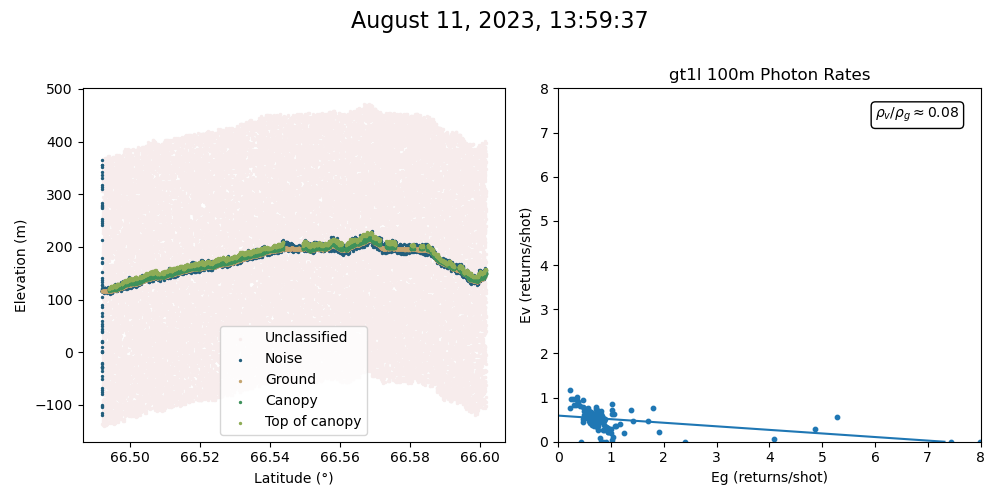

In [3]:
%matplotlib ipympl

dirpath = '../data/rovaniemi_w/'
all_ATL03, all_ATL08 = track_pairs(dirpath)

N = 45
gt = 'gt1l'
atl03path = all_ATL03[N]
atl08path = all_ATL08[N]

pvpg_gt(atl03path, atl08path, gt)

### Segments with abnormally high $E_g$

In [ ]:
atl03 = ATL03(atl03path, atl08path, gt)
atl08 = ATL08(atl08path, gt)
atl08.df[atl08.df.Eg > 4]

### Show location of relevant segments on a map

In [ ]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# Sample DataFrame with latitude and longitude columns
# Replace this with your actual DataFrame
df = atl08.df.loc[:,['lat','lon']]
df_outlier = atl08.df[atl08.df.Eg > 4].loc[:,['lat','lon']]

# Create a map with Cartopy
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize = (10,7))
ax.set_extent([25.15,25.35,66.45,66.65])  # Set the map extent to cover Edinburgh

# Plot points from the DataFrame
ax.scatter(df['lon'], df['lat'], color='b', marker='o', label='Data Points', zorder=3, s=10)
ax.scatter(df_outlier['lon'], df_outlier['lat'], color='r', marker='x', label='Outliers', zorder=4, s=10)

tif = rasterio.open(dirpath + '/rovaniemi_image.tiff')
show(tif, ax=ax, transform=ccrs.PlateCarree())

# Add labels, title, and legend
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Map of Rovaniemi with Data Points')
ax.legend()

# Add latitude and longitude gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=1, color='gray', alpha=0.5)
gl.top_labels = gl.right_labels = False  # Updated lines
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

# Show the plot
plt.show()

All the outliers occur on or partially on patches of darker marshland. The lighter marshland visible in the bottom left figure does not yield similar outliers. Instead of deleting the entries with arbitrarily large values of Ev, I changed the value of these entries to 0. The classified track above show segments with no canopy cover and the track plot shows that all problem entries occurred over such treeless spaces. Thus, I felt that this change was justified; it seems like more of a data entry issue that data collection issue.

<center><img src="../data/rovaniemi_w/marsh1.png" width=440> <img src="../data/rovaniemi_w/marsh2.png" width=400></center>

<center><img src="../data/rovaniemi_w/plot1.png" width=500> <img src="../data/rovaniemi_w/plot2.png" width=500></center>

### Penalized orthogonal distance regression



In [3]:
# %matplotlib ipympl

# dirpath = '../data/rovaniemi_w/'
# all_ATL03, all_ATL08 = track_pairs(dirpath)

# # N = len(all_ATL03)
# gt = 'gt1r'

# N = np.arange(0,21,1)
# S = [.1]
# for i in N:
#     for s in S:
#         print('N = ' + str(i) + ', s = ' + str(s))
#         atl03path = all_ATL03[i]
#         atl08path = all_ATL08[i]
#         pvpg_gt_penalized(atl03path, atl08path, gt, s)

In [8]:
# -*- coding: utf-8 -*-
"""
Created on Wed Dec 20 17:28:04 2023

@author: s1803229
"""

from scripts.imports import os, glob, pdb, np, h5py, pd, xr, gpd, Proj, Transformer, CRS, \
                        plt, cmap, Model, Data, ODR, datetime, rasterio, show, \
                        ccrs, cfeature
from scripts.classes_fixed import *
from scipy.optimize import least_squares

def parse_filename_datetime(filename):
    # Extracting only the filename from the full path
    filename_only = filename.split('/')[-1]
    date_str = filename_only.split('_')[2][:14]  # Extracting yyyymmddhhmmss part
    datetime_obj = datetime.strptime(date_str, '%Y%m%d%H%M%S')
    return datetime_obj.strftime('%B %d, %Y, %H:%M:%S')

def pvpg_penalized(atl03path, atl08path, s = .1, j = None):
    
    i = 0
    
    tracks = ['gt1r', 'gt1l', 'gt2r', 'gt2l', 'gt3r', 'gt3l']
    #A = h5py.File(atl03path, 'r')
    
    fig, axes = plt.subplots(6, 3, figsize=(8, 30))
    ax = axes.flatten()
    
    # Extracting date and time from the filename
    title_date = parse_filename_datetime(atl03path)

    # Set the figure title
    if j != None:
        fig.suptitle(title_date + ' - N = ' + str(j), fontsize=16)
    else:
        fig.suptitle(title_date, fontsize=16)

    for gt in tracks:
        
        try:
            atl03 = ATL03(atl03path, atl08path, gt)
        except (KeyError, ValueError, OSError) as e:
            i += 3
            continue
        atl08 = ATL08(atl08path, gt)

        atl03.plot(ax[i])

        def model(params, x):
            return params[0]*x + params[1]
        
        def residuals(params, x, y):
            return np.abs(model(params, x) - y)/np.sqrt(1 + params[0]**2)

        X = atl08.df.Eg
        Y = atl08.df.Ev
        
        initial_guess = [-1,np.max(Y)]
        
        initial = least_squares(residuals, initial_guess, loss='arctan', f_scale=s, args=(X, Y), bounds = ([-50,0],[-1/50,16]))
            
        a_guess, b_guess = initial.x
        
        ax[i+1].set_title(f"{gt} Photon Rates - Arctan Loss", fontsize=8)
        ax[i+1].scatter(X, Y, s=10)
        ax[i+1].plot(np.array([-10,20]), model([a_guess, b_guess], np.array([-10,20])), label='Orthogonal Distance Regression', color='red', linestyle='--')
        ax[i+1].set_xlabel('Eg (returns/shot)')
        ax[i+1].set_ylabel('Ev (returns/shot)')
        ax[i+1].set_xlim(0,12)
        ax[i+1].set_ylim(0,12)
        ax[i+1].annotate(r'$\rho_v/\rho_g \approx {:.2f}$'.format(-a_guess),
                       xy=(.95,.95),
                       xycoords='axes fraction',
                       ha='right',
                       va='top',
                       bbox=dict(boxstyle="round,pad=0.3",
                                 edgecolor="black",
                                 facecolor="white"))
        
        initial_guess = [-1,np.max(Y)/3 + 2*np.mean(Y)/3]
        
        result = least_squares(residuals, initial_guess, loss='arctan', f_scale=s, args=(X, Y), bounds = ([-50,0],[-1/50,16]))
        
        a_opt, b_opt = result.x
        
        ax[i+2].set_title(f"{gt} Photon Rates - Standard ODR", fontsize=8)
        ax[i+2].scatter(X, Y, s=10)
        ax[i+2].plot(np.array([-10,20]), model([a_opt, b_opt], np.array([-10,20])), label='Orthogonal Distance Regression', color='red', linestyle='--')
        ax[i+2].set_xlabel('Eg (returns/shot)')
        ax[i+2].set_ylabel('Ev (returns/shot)')
        ax[i+2].set_xlim(0,12)
        ax[i+2].set_ylim(0,12)
        ax[i+2].annotate(r'$\rho_v/\rho_g \approx {:.2f}$'.format(-a_opt),
                       xy=(.95,.95),
                       xycoords='axes fraction',
                       ha='right',
                       va='top',
                       bbox=dict(boxstyle="round,pad=0.3",
                                 edgecolor="black",
                                 facecolor="white"))
        i += 3
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust the layout to make room for the suptitle
    plt.show()
    return


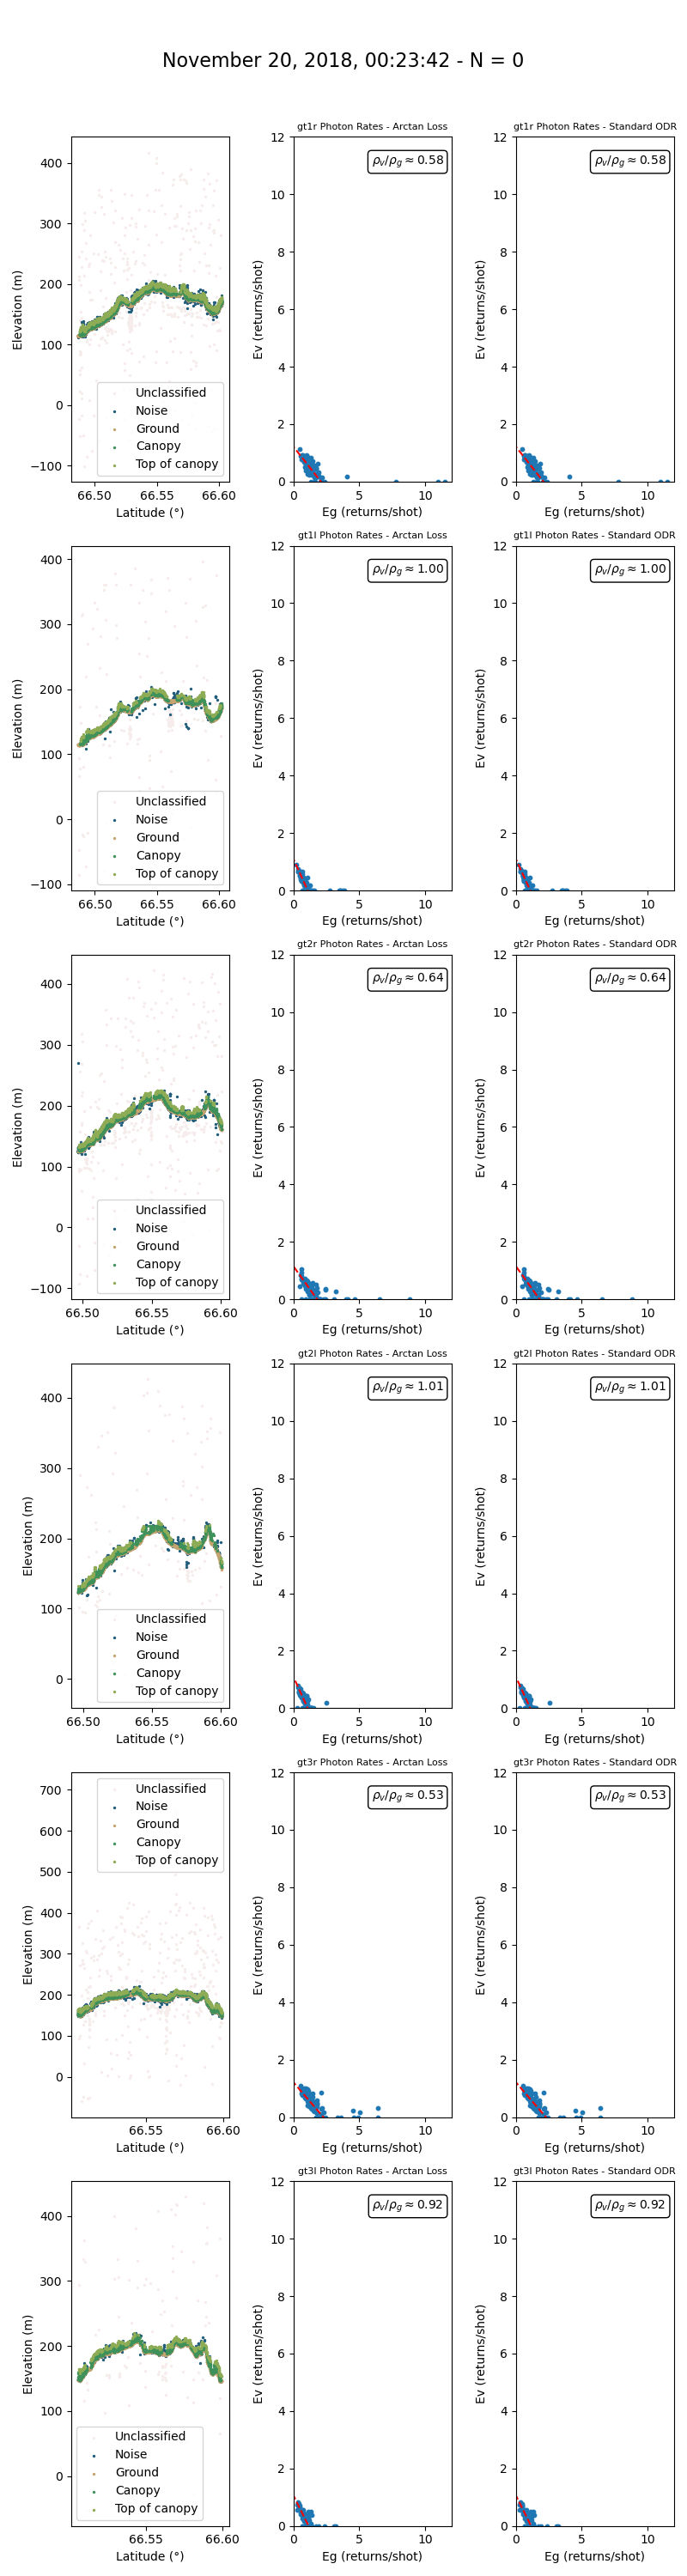

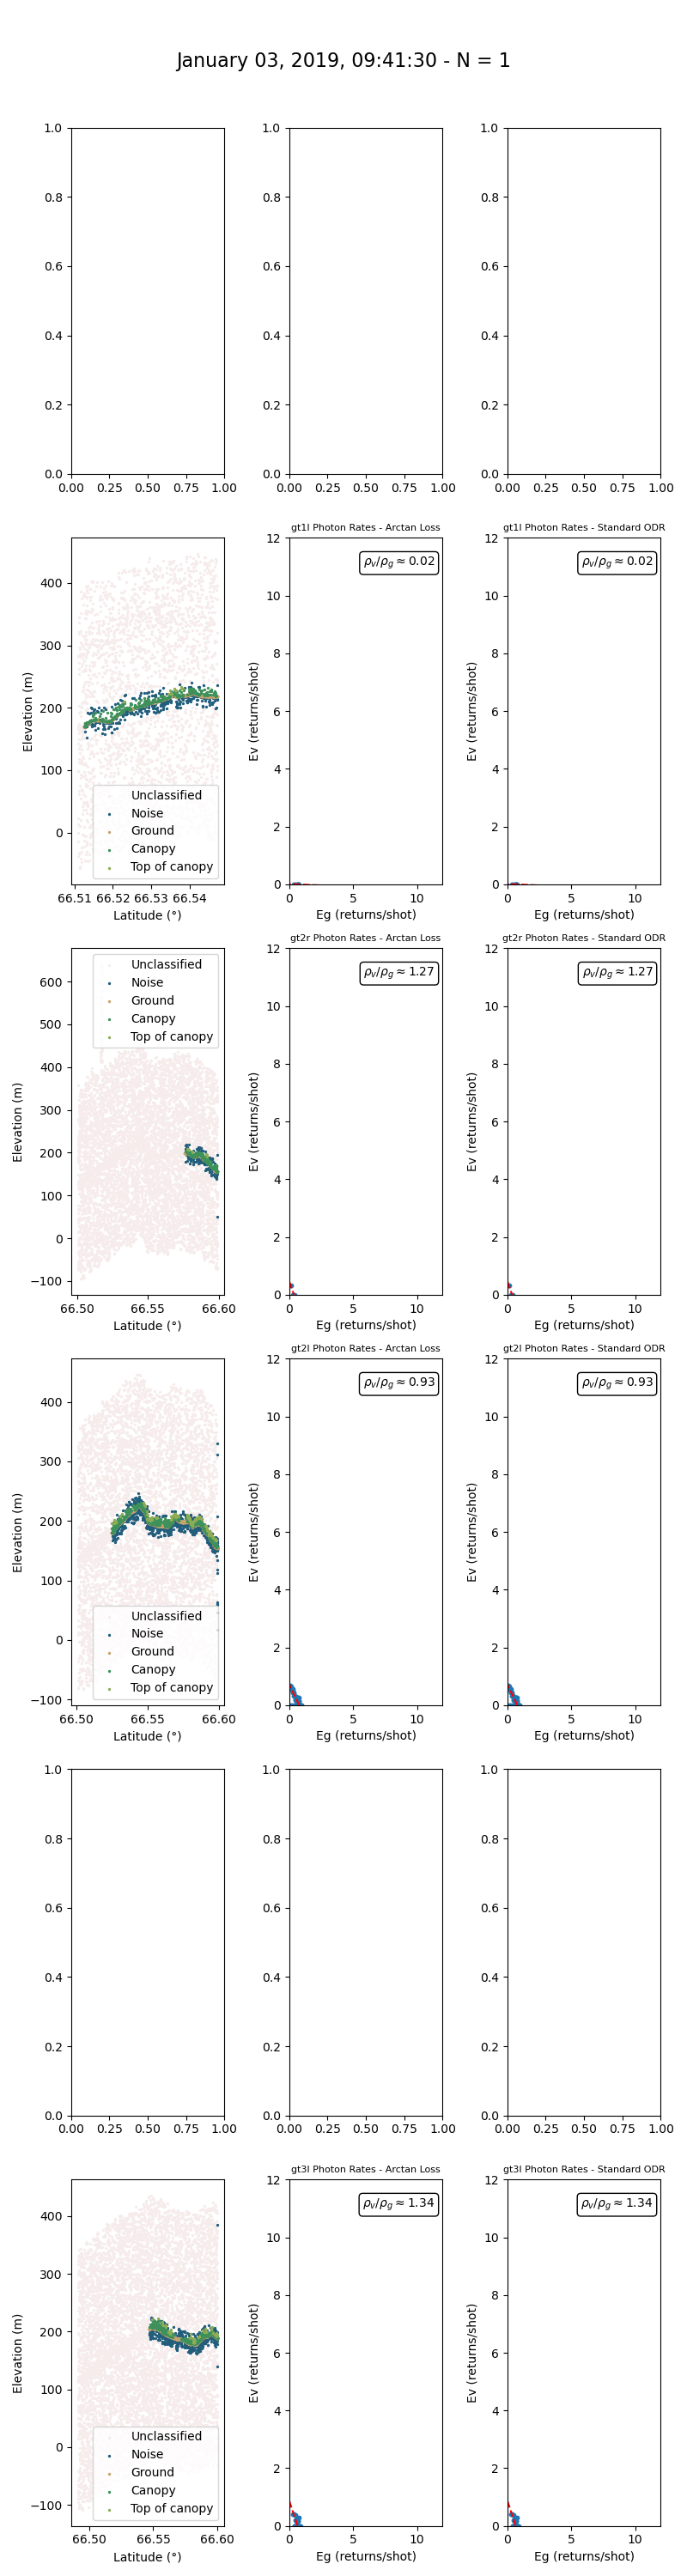

C:\Users\s1803229\AppData\Local\Temp\ipykernel_8316\27842135.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(6, 3, figsize=(8, 30))


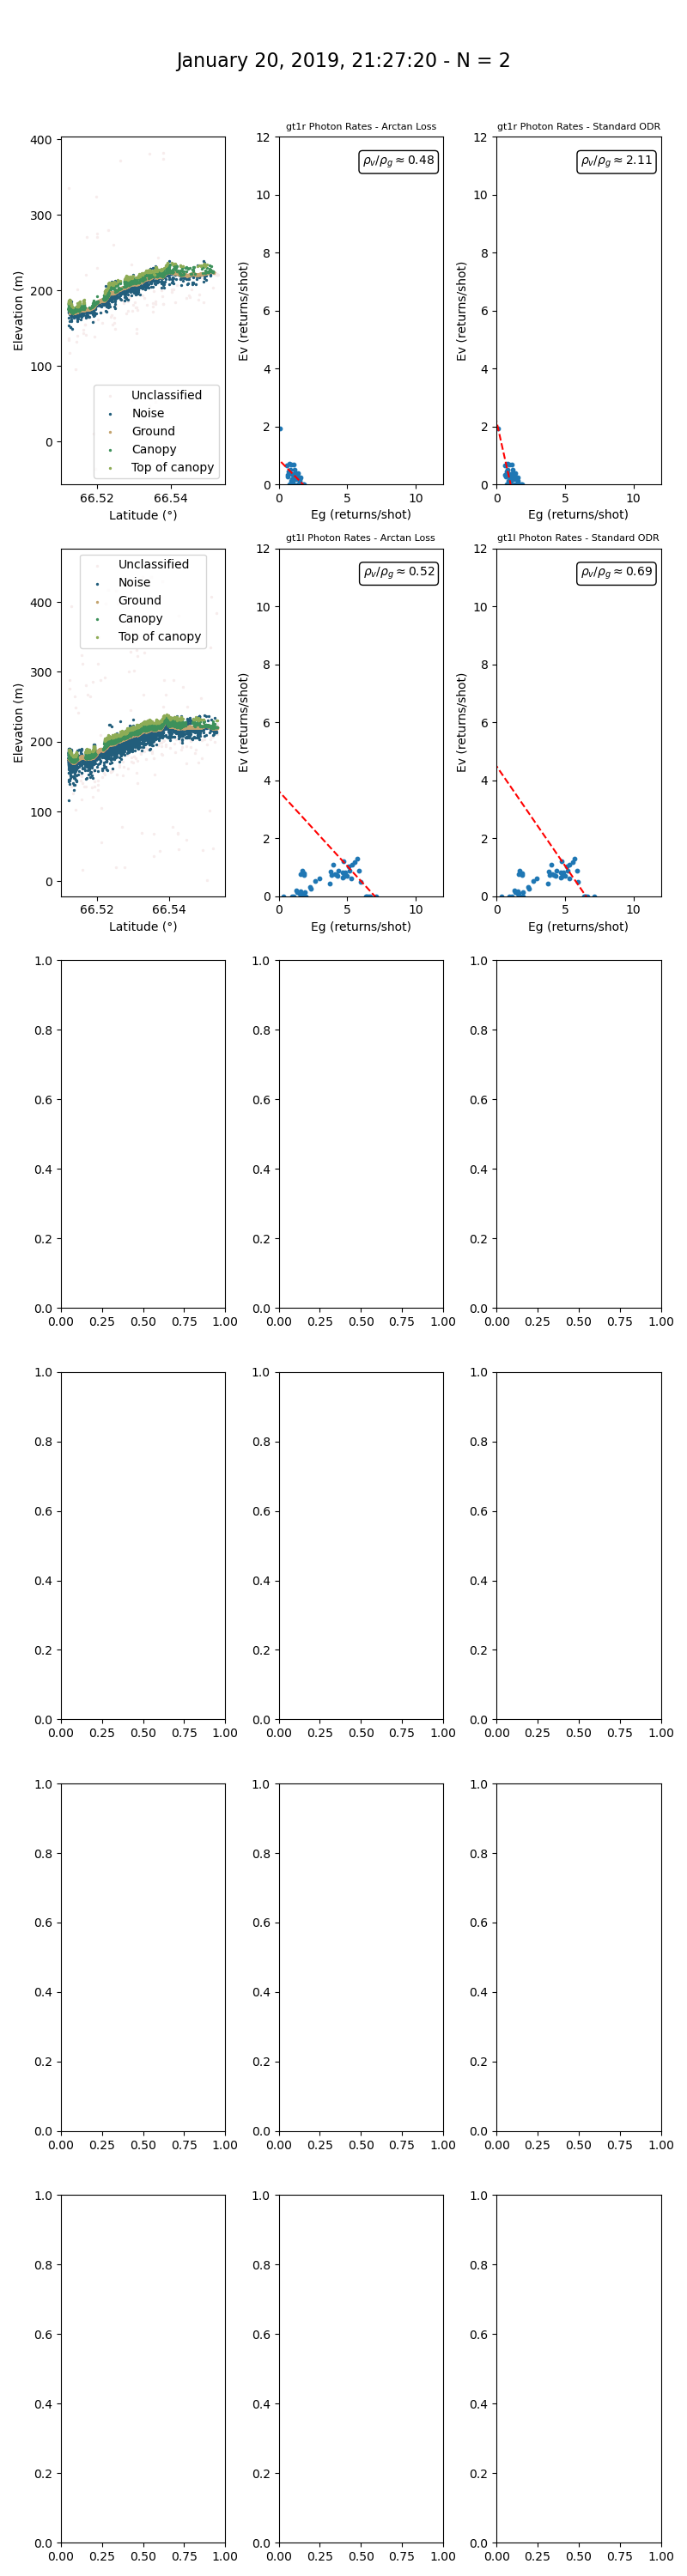

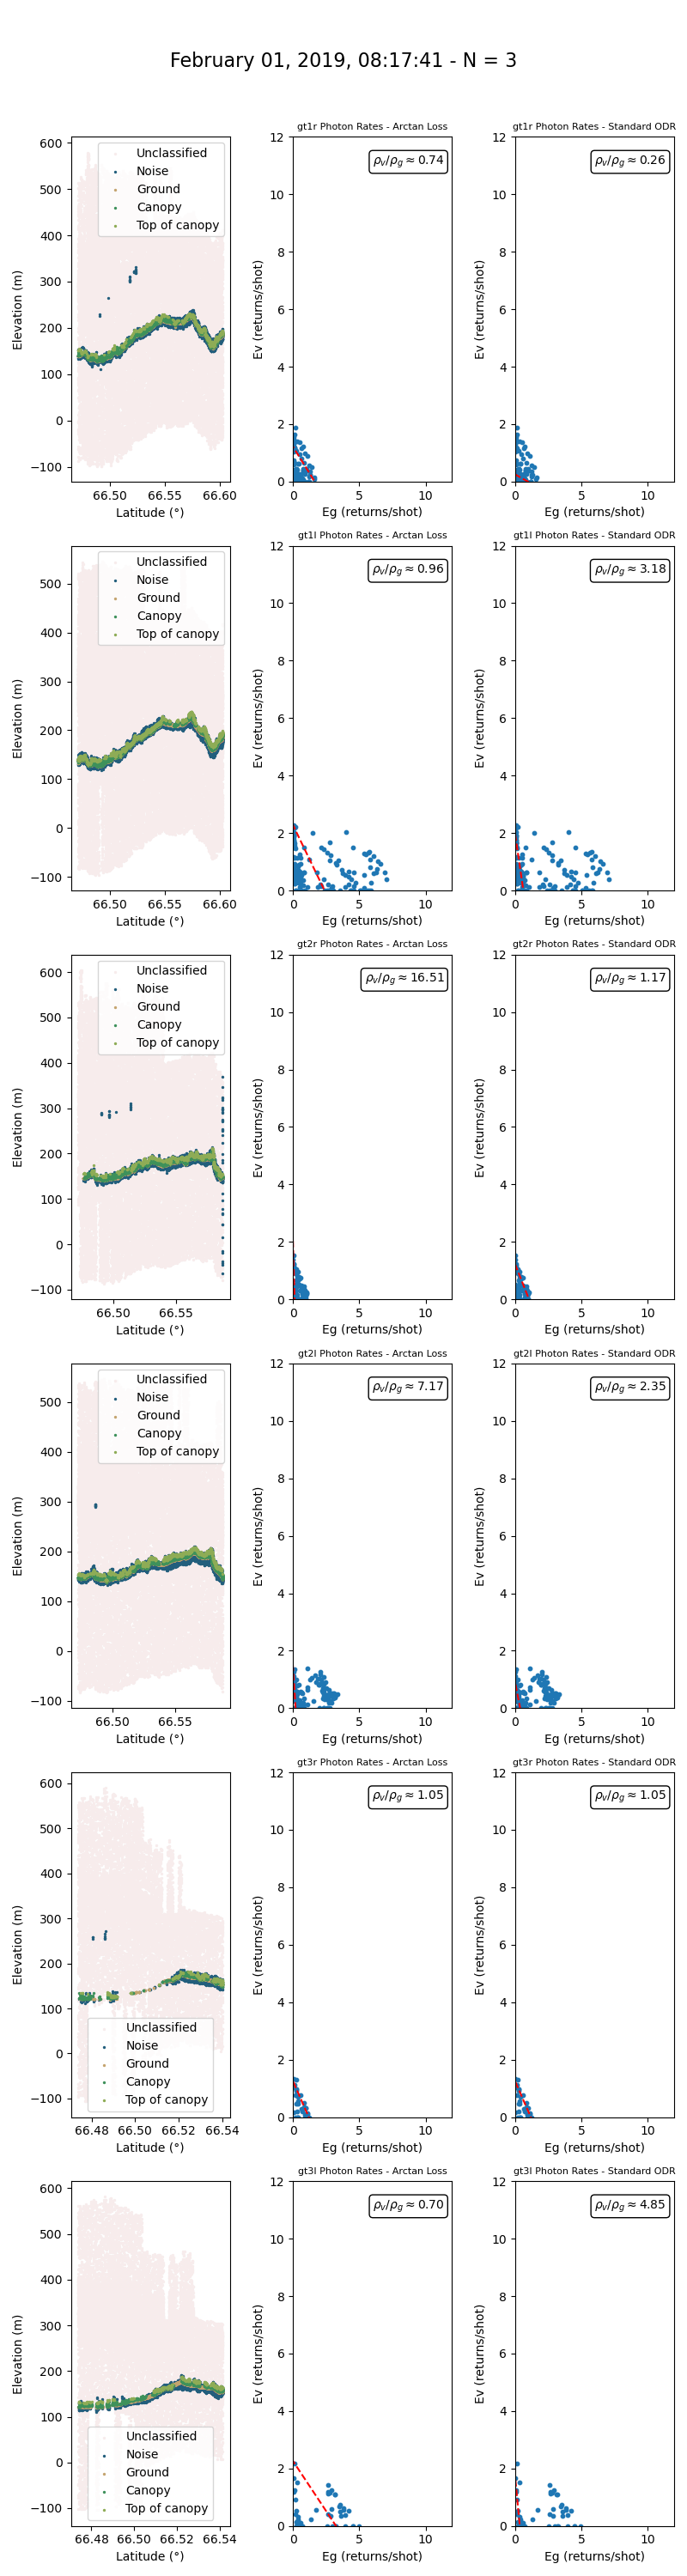

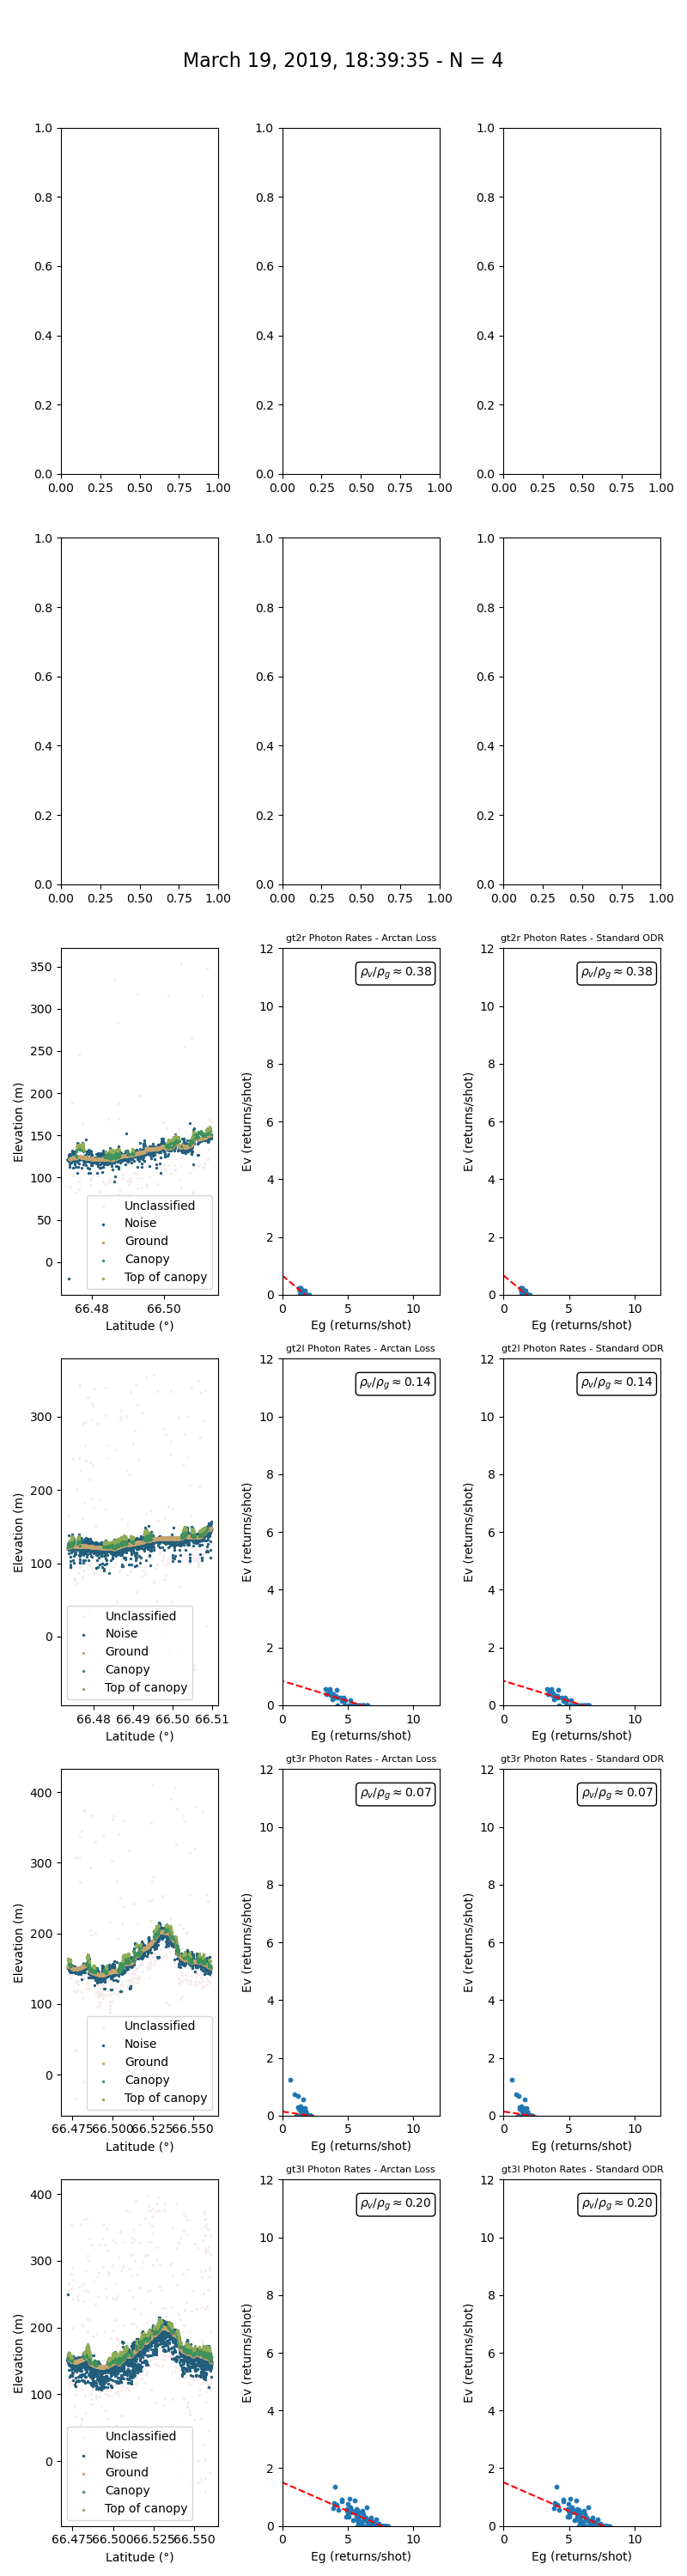

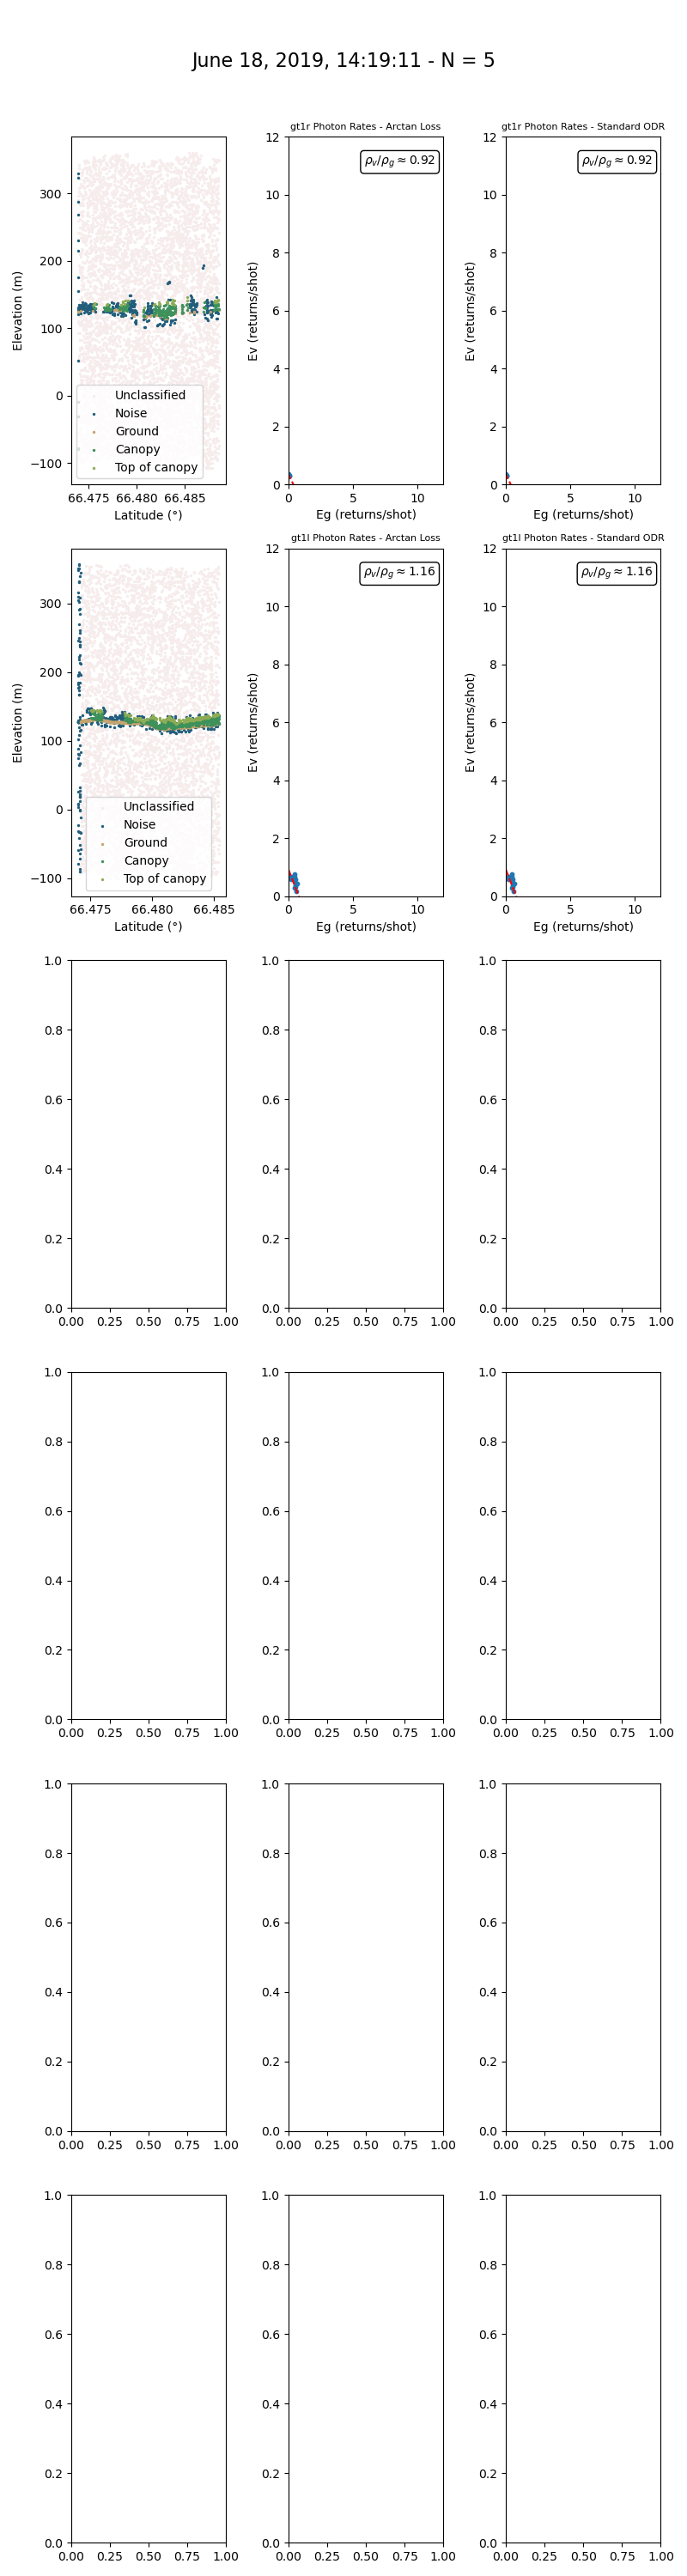

In [9]:
%matplotlib ipympl

dirpath = '../data/rovaniemi_w/'
all_ATL03, all_ATL08 = track_pairs(dirpath)
N = len(all_ATL03)

for j in range(0,6):
    pvpg_penalized(all_ATL03[j],all_ATL08[j], s=.1, j=j)